Explores computing a MDP over a state space that maps to an underlying graph.  This is a more general state space than the metric spaces we've previously been using.  This is also a good test of the Principle of Opportunity (value is derived from distance from reward).



# Preliminaries

In [577]:


import numpy as np
import operator


import matplotlib as mpl
import matplotlib.pyplot as plt


import IPython.display as dp
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 

import time

import numba as nb

from timeit import default_timer as timer


import networkx as nx



In [578]:
# These values are all tuned to generate plots for the dissertation.
font_size=9
# Increase the font size for EPS plots in the paper
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : font_size}

mpl.rc('font', **font)

# Node size
sz = 500
figsize = (5,5) 

!mkdir  images

mkdir: cannot create directory ‘images’: File exists


## GPU value iteration implementation

This version assumes the state space is a 1-D state space where the state $s$ maps to the node $n$ in a graph $G$ with $N$ nodes and $E$ edges.  From the perspective of this algorithm, this is just a simple MDP with a 1-D state space and a transition function $T$.  The graph $G$ is treated as a undirected graph where every edge $e$ indicates a transition (an action) that can be taken from a node $n_1$ that will lead to a transition to a new node $n_2$.  Likewise, this also means that a corresponding transition (action) from $n_2$ to $n_1$ exists.  We assume that this is a deterministic MDP and therefore the probability of these transitions is $1.0$.  Note that the number of actions available at any node is dependent on the number of (outgoing) edges from that node.

In [579]:
#%load_ext autoreload
#%autoreload 2

#import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = ""
#del os.environ["NUMBA_ENABLE_CUDASIM"]

import numpy as np
import math

import numba
from numba import cuda

@cuda.jit
def bellman_update_st(xmax, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma):
    
    num_actions = T_gpu.shape[1]  # assumes 1-d state space definition

    x = cuda.grid( 1 )

    #print( "pos %d -> x %d, y %d" % (pos, x, y ) ) 
    if x >= xmax:
      return


    # immediate reward
    r = R_gpu[ x ]

    # bellman update for stochastic mdp

    # first we have to compute the future expected value of taking
    # an action from this state.  We will keep track of the best
    # value we find in max_V.

    max_V = -np.inf

    # There is some additional parallelism we could take advantage of in here
    # if we'd like to kick off additional threads in parallel.  This will
    # get tricky because we'll need to either use atomic sum operations
    # or we'll need to build a pipeline of kernels to perform a reduction.
    # For now, performing the loop below on each thread, which will make
    # the algorithm slower than it could be on the GPU.
    for a in range(num_actions):

      # We have to sum up over all s' the expected future values
      V_sum = 0

      viable_action = 0

      for xn in range(xmax):
        # probability of transitioning to the next state given
        # the current state and action
        P_n = T_gpu[ x, a, xn ]

        if P_n > 0.0:
          viable_action = 1

        # value of next state
        V_n = V_i[ xn ]

        # expected future value of this transition
        # Note here we assume that reward is the same regardless of action, 
        # which is to say the reward function is R(s) rather than R(s, a).
        # This could easily be modified here.
        V_sum += P_n * ( r +  gamma * V_n )
        #print( 'x ', x, ' a ', a, ' xn ', xn, ' Vn ', V_n, ' Pn ', P_n,' r', r, ' max_V ', max_V, ' V_sum ', V_sum )
      
      if viable_action:
        #print( 'x ', x, ' a ', a, ' r', r, ' max_V ', max_V, ' V_sum ', V_sum )
        max_V = max( max_V, V_sum )

    # residual 
    res = abs(max_V - V_i[ x ])

    # update the value 
    V_o[ x ] = max_V

    # atomically update the residual
    cuda.atomic.max( residual_gpu, 0, res ) 
    


def numba_value_iteration_st(N, V, T, R, epsilon, gamma):
    # Move data to GPU so we can do two operations on it
    V_gpu_a = cuda.to_device(V)
    V_gpu_b = cuda.to_device(V)
    T_gpu = cuda.to_device(T)
    R_gpu = cuda.to_device(R)

    num_actions = T.shape[1]

    residual = np.array( [ -np.inf ], dtype=V.dtype )

    start = timer()    

    count = 0
    while count == 0 or ( residual[0] > epsilon ):  # and count < 100 ):

      # Set up a ping-pong between the two value function buffers
      # so that V_i (input) is fixed during the iteration and
      # V_o (output) is updated at each iteration.
      if count % 2 == 0:
        V_i = V_gpu_a
        V_o = V_gpu_b
      else:
        V_i = V_gpu_b
        V_o = V_gpu_a

      # reset residual for next run
      residual[0] = -np.inf
    
      residual_gpu = cuda.to_device( residual )

      end1 = timer()

      num_threads = N
      threadsperblock = 256
      blockspergrid_x = math.ceil(N / threadsperblock)
      blockspergrid = blockspergrid_x     

      ### Perform Bellman upate
      bellman_update_st[blockspergrid,threadsperblock](N, V_i, V_o, T_gpu, R_gpu, residual_gpu, gamma)

      end2 = timer()

      residual = residual_gpu.copy_to_host()

      end3 = timer()

      #print( "count %d: %f - %f secs (%f + %f + %f)" % (count, residual[0], end3 - start, end1 - start, end2-end1, end3-end2) )
      start = end3

      #np.save( 'val_iter/hist_%d.npy' % count, V_gpu.copy_to_host() )

      count += 1 


    return V_o.copy_to_host()



# Graph

Generate a graph $G$ using the networkx library.  Show the graph with a label indicating the id of each node.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


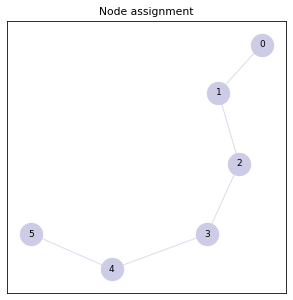

In [580]:
seed=5
np.random.seed( seed )  
#G = nx.generators.random_graphs.random_lobster( 7, .7, .9, seed=seed )
#G = nx.generators.random_graphs.random_lobster( 5, .7, .9, seed=seed )
G = nx.generators.random_graphs.random_lobster( 5, 0, 0, seed=seed ) # debug

nodes = np.array( list(G.nodes) )
N = len(nodes)

default = 1/np.sqrt(N)

pos=nx.spring_layout(G, k=default*15, iterations=400)


o = np.ones( N )
plt.figure(figsize=figsize)
plt.title( "Node assignment" )
edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True, font_size=font_size,)


Build up a dictionary which describes all of the outgoing edges from each node.

In [581]:
def edges_from_graph( G ):
  # Instead generate a dictionary with key of the node and value of a list of 
  # outgoing nodes
  edges = {}
  for edge in list(G.edges):
    #print( edge, type(edge) )
    src, dst = edge

    # Generate from src to dst
    try:
      edges[src] += [ dst ]
    except KeyError:
      edges[src] = [ dst ]

    # And since this is a undirected graph generate the reverse transition
    try:
      edges[dst] += [ src ]
    except KeyError:
      edges[dst] = [ src ]

  # Determine the maximum number of outgoing transitions from any node
  max_out_degree = -1
  for src, outgoing in edges.items():
    max_out_degree = max( max_out_degree, len(outgoing) )

  print( 'edges: ', edges )
  print( 'max_out_degree: ', max_out_degree )

  return (edges, max_out_degree)

edges, max_out_degree = edges_from_graph( G )


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4]}
max_out_degree:  2


# Transition Function

Now generate a transition function for the MDP from this graph.

In [582]:

# Generate a transition function from an undirected graph
# We assume that transitions to and from the connected nodes
# are possible and correspond to an action that is available
# from both nodes.  We also assume this transition is deterministic.
# We assume that all nodes are connected -- that they have at least
# one incoming/outgoing edge.  

def gen_transition_function(N, edges, max_out_degree):

  # The transition function is T( s, a, s' ).  We assume that there is an
  # ordered list of edges from each node.  We assume that there is at least
  # one outgoing edge from each node.  We assign the actions $a \in {0, 1, \cdots}$ 
  # to that ordered list of edges.  If a node k has an outgoing degree of D, then
  # only that many actions are defined for that node $a_k \in {0, \cdots, D}$.
  # We assume a maximum outgoing degree which is supplied by the caller.  This 
  # allows us to create a regular rectangular ND-array, though it will be an 
  # inefficient representation because there will be so many unnecessary zeros 
  # in it.  As an optimization for the future, could represent it as a sparse 
  # array to minimize the amount of memory consumed by the array.
  T = np.zeros( (N, max_out_degree, N)  )


  print( "Building transition function" )
  
  # Extract s, a, sp (s-prime) from the edges
  for s, outgoing in edges.items():

    for a, sp in enumerate(outgoing):

      # Assume a deterministic transition
      T[ s, a, sp ] = 1.0
    
  return T
  

In [583]:
T = gen_transition_function( N, edges, max_out_degree )

Building transition function


# Reward Function

Let's define a reward function with a single positive reward "somewhere" in the graph.  We choose the location arbitrarily by picking the node id which is half way through the node list.

In [584]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Put a reward at a random node in the graph.  I picked node
# a node arbitrarily and put a reward at that location.
R[int(N/2)] = 10

# Solving MDP


In [585]:


# define bellman residual threshold
epsilon = .00001

# discount factor
gamma = 0.9

print( "Solving MDP" )
V = np.zeros( (N) )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )



Solving MDP


/home/bertrjr1/anaconda3/envs/gpu2/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (92) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Now graph the result.  First show the graph nodes and then the reward function.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


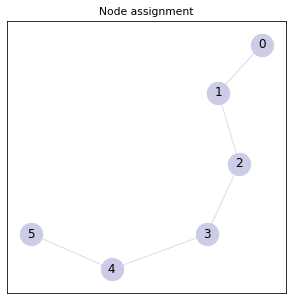

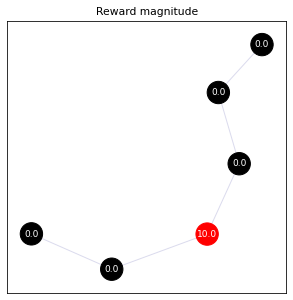

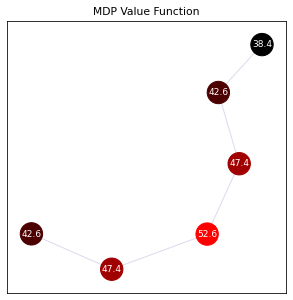

In [586]:
def plot_mdp_result( G, pos, N, R, V_det, file_prefix=None ):

  o = np.ones( N )

  #pos=nx.spring_layout(G,iterations=100)
  plt.figure(figsize=figsize)
  plt.title( "Node assignment" )
  edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
  nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True)


  # Rewards
  node_colors = np.c_[ (R-R.min())/(R.max()-R.min()), np.zeros( N ), np.zeros( N ) ]
  cmap = plt.cm.coolwarm
    
  if file_prefix:
    plt.savefig( 'images/%s_node.eps' % file_prefix, format='eps', dpi=75 )

  plt.figure(figsize=figsize)
  plt.title( "Reward magnitude" )


  edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
  n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
  e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=edge_colors)
  label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
  reward_labels = {}
  for i in range(N):
    reward_labels[i] = R[i]

  l = nx.draw_networkx_labels(G, pos, labels=reward_labels, font_color='white', font_size=font_size, bbox=label_options)


  # Value
  col = (V_det-V_det.min())/(V_det.max()-V_det.min()) 
  node_colors = np.c_[ col , 0*col, 0*col]
  cmap = plt.cm.coolwarm

  if file_prefix:
    plt.savefig( 'images/%s_rewards.eps' % file_prefix, format='eps', dpi=75 )


  plt.figure(figsize=figsize)
  plt.title( "MDP Value Function" )

  n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
  e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=[.8,.8,.9,.7])
  label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
  labels = {}
  for i in range(N):
    labels[i] = f'%.1f' % V_det[i]

  l = nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=font_size, bbox=label_options)

  if file_prefix:
    plt.savefig( 'images/%s_valfunc.eps' % file_prefix, format='eps', dpi=75 )



plot_mdp_result( G, pos, N, R, V_det )


# FastMDP version




## Distance through graph

Show distance through the graph from the reward.

In [587]:

# Pre-compute distance from each node to every other node
dists = dict(nx.shortest_path_length(G))


In [588]:

# Let's see, the reward is at state int(N/2), so we need distance to that reward.
r = int(N/2)
d = np.zeros(N)

for i in range(N):
  d[i] = dists[r][i] 


## Peak Magnitude

In [589]:
# Compute the magnitude of the peak.  
peak = 10. / (1 - gamma**2)
peak, V_det[r]

(52.63157894736844, 52.63154006589952)

## Compute value function

In [590]:
# Compute the value function
V_pred = peak * gamma ** d


Make sure the FastMDP value function $V_{pred}$ is the same as the one we computed with value iteration $V_{det}$.  All the values should be less than or equal to the Bellman residual threshold that we specified in the value iteraiton call.  

In [591]:
V_pred - V_det

array([4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05])

And go ahead and plot them both side by side just for grins.

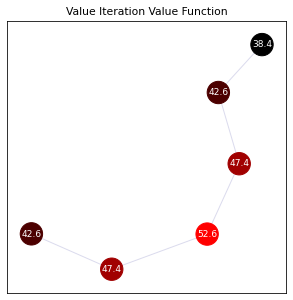

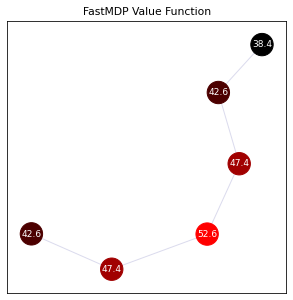

In [592]:
def plot_compare( G, N, V_det, V_pred, title1=None, title2=None, file1=None, file2=None ):

  # Value
  if V_det.max() == 0:
    col = 1 - np.abs( V_det/V_det.min() ) 
  else:
    col = (V_det-V_det.min())/(V_det.max()-V_det.min()) 
  node_colors = np.c_[ col , 0*col, 0*col]
  cmap = plt.cm.coolwarm

  plt.figure(figsize=figsize)

  if title1:
    plt.title( title1 )
  else:
    plt.title( "Value Iteration Value Function" )

  n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
  e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=[.8,.8,.9,.7])
  label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
  labels = {}
  for i in range(N):
    labels[i] = f'%.1f' % V_det[i]

  l = nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=font_size, bbox=label_options)


  if file1:
        plt.savefig( 'images/%s' % file1, format='eps', dpi=75 )

  plt.figure(figsize=figsize)
  if title2:
    plt.title( title2 )
  else:
    plt.title( "FastMDP Value Function" )

  if V_pred.max() == 0:
    col = 1 - np.abs( V_pred/V_pred.min() ) 
  else:
    col = (V_pred-V_pred.min())/(V_pred.max()-V_pred.min()) 
  node_colors = np.c_[ col , 0*col, 0*col]

  n = nx.draw_networkx_nodes(G, pos,  node_size=sz, node_color=node_colors, cmap=cmap)
  e = nx.draw_networkx_edges(G, pos,  node_size=sz, edge_color=[.8,.8,.9,.7])
  label_options = {"ec": "k", "fc": "white", "alpha": 0.0}
  labels = {}
  for i in range(N):
    labels[i] = f'%.1f' % V_pred[i]

  l = nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_size=font_size, bbox=label_options)

  if file2:
        plt.savefig( 'images/%s' % file2, format='eps', dpi=75 )


plot_compare( G, N, V_det, V_pred )


# Library

Wrapping the above into some code that will make it easier to test variations below.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4]}
max_out_degree:  2
Building transition function


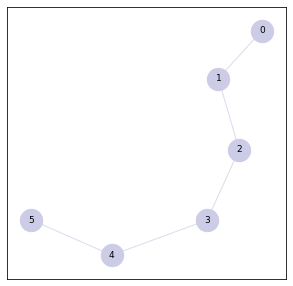

In [593]:


def generate_test_case(size=5, a=0, b=0, seed=5):
  np.random.seed( seed )  
  G = nx.generators.random_graphs.random_lobster( size, a, b, seed=seed ) # debug

  nodes = np.array( list(G.nodes) )
  N = len(nodes)

  default = 1/np.sqrt(N)

  pos=nx.spring_layout(G, k=default*15, iterations=400)


  o = np.ones( N )
  plt.figure(figsize=figsize)
  #plt.title( "Node assignment" )
  edge_colors= np.c_[ [ .8 * o, .8 * o, .9 * o, .7 * o ] ].T
  nx.draw_networkx(G, pos,  node_size=sz, node_color=(.8, .8, .9, 1.0), edge_color=edge_colors, with_labels=True, font_size=font_size,)

  edges, max_out_degree = edges_from_graph( G )

  T = gen_transition_function( N, edges, max_out_degree )

  # Pre-compute distance from each node to every other node
  dists = dict(nx.shortest_path_length(G))


  return (G, nodes, N, pos, edges, max_out_degree, T, dists )


def super_simple_debug_graph():
  return generate_test_case(size=5, a=0, b=0)

def representative_graph():
  return generate_test_case(size=5, a=0.7, b=0.9)

def complex_graph():
  return generate_test_case(size=7, a=0.7, b=0.9)

(G, nodes, N, pos, edges, max_out_degree, T, dists ) = super_simple_debug_graph()


# Single positive reward

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6, 8, 9], 6: [5, 7], 8: [5], 9: [5, 10, 11, 12, 13, 14, 15, 16], 7: [6], 10: [9], 11: [9], 12: [9], 13: [9], 14: [9], 15: [9], 16: [9]}
max_out_degree:  8
Building transition function


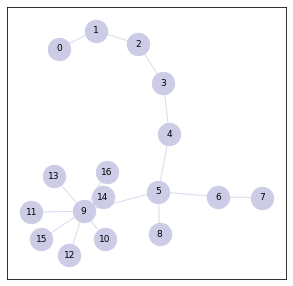

In [653]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = representative_graph()




In [654]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ int(N/2) ]

for rwd in pos_rewards:
  R[rwd] = 10


In [655]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = np.zeros( (N) )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

Solving MDP


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


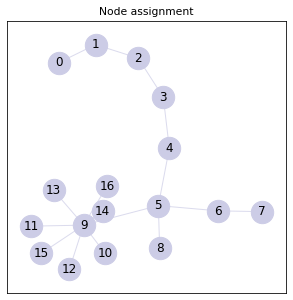

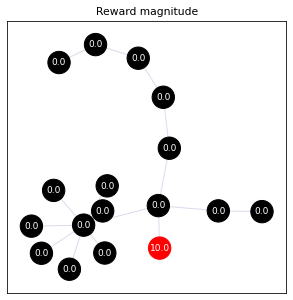

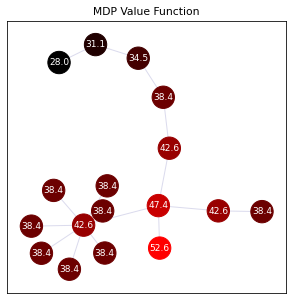

In [656]:
plot_mdp_result( G, pos, N, R, V_det, file_prefix='graph_mdp_singlepos' )


In [657]:

# Let's see, the reward is at state int(N/2), so we need distance to that reward.
r = int(N/2)
M = len(pos_rewards) # number of peaks
d = np.zeros( (N, M) )

for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  for s_i in range(N):
    # Distance from each state (s_i) to each positive reward (s_r) 
 
    # extract the distance from the dict into our more convenient 2D
    # numpy array.  when we index this, we are saying distance from 
    # state s_i to the m'th peak.
    d[s_i,m] = dists[s_i][s_r]  


In [658]:
# Compute the magnitude of the peak.
peak_mags = np.zeros( (M) )

for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  peak_mags[m] = 10. / (1 - gamma**2)  # assuming each peak has pos reward of 10 right now

  print( f'peak {m} magnitude {peak_mags[m]}  value function {V_det[s_r]}' )

peak 0 magnitude 52.63157894736844  value function 52.63154006589952


In [659]:
# Compute the value function using the FastMDP method

# First, compute the value function that would result from each peak
V_pred_each = np.zeros( (M, N) )  # num peaks X num states
for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  V_pred_each[m,:] = peak_mags[m] * gamma ** d[:,m]

# Now determine the value function by performing the max over each peak
V_pred = np.max( V_pred_each, axis=0 ) 

In [660]:
V_pred - V_det

array([3.88814689e-05, 4.32016321e-05, 3.88814689e-05, 4.32016321e-05,
       3.88814689e-05, 4.32016321e-05, 3.88814689e-05, 4.32016321e-05,
       3.88814689e-05, 3.88814689e-05, 4.32016321e-05, 4.32016321e-05,
       4.32016321e-05, 4.32016321e-05, 4.32016321e-05, 4.32016321e-05,
       4.32016321e-05])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


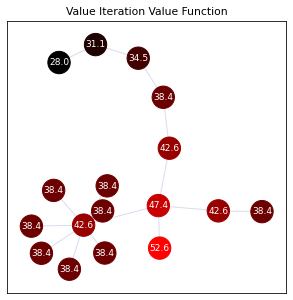

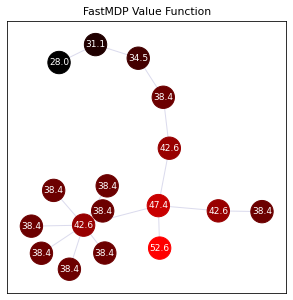

In [661]:
plot_compare( G, N, V_det, V_pred, file1='graph_mdp_singlepos_valiter.eps', file2='graph_mdp_singlepos_fastmpd.eps' )



# Multiple positive rewards

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6, 8, 9], 6: [5, 7], 8: [5], 9: [5, 10, 11, 12, 13, 14, 15, 16], 7: [6], 10: [9], 11: [9], 12: [9], 13: [9], 14: [9], 15: [9], 16: [9]}
max_out_degree:  8
Building transition function


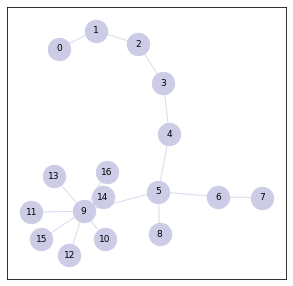

In [662]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = representative_graph()
plt.savefig( 'images/graph_mdp_single.eps', format='eps', dpi=75 )

In [663]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ int(N/2), int(N*1/4), int(N*1/10) ]

for rwd in pos_rewards:
  R[rwd] = 10


In [664]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = np.zeros( (N) )
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )

Solving MDP


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


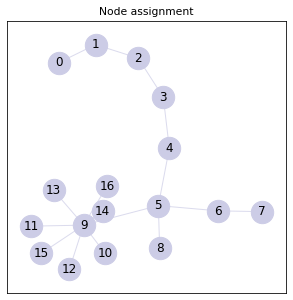

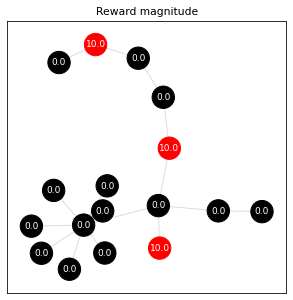

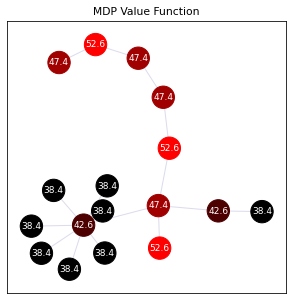

In [665]:
plot_mdp_result( G, pos, N, R, V_det, file_prefix='graph_mdp_multipos' )

In [666]:

# Let's see, the reward is at state int(N/2), so we need distance to that reward.
r = int(N/2)
M = len(pos_rewards) # number of peaks
d = np.zeros( (N, M) )

for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  for s_i in range(N):
    # Distance from each state (s_i) to each positive reward (s_r) 
 
    # extract the distance from the dict into our more convenient 2D
    # numpy array.  when we index this, we are saying distance from 
    # state s_i to the m'th peak.
    d[s_i,m] = dists[s_i][s_r]  


In [667]:
# Compute the magnitude of the peak.
peak_mags = np.zeros( (M) )

for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  peak_mags[m] = 10. / (1 - gamma**2)  # assuming each peak has pos reward of 10 right now

  print( f'peak {m} magnitude {peak_mags[m]}  value function {V_det[s_r]}' )

peak 0 magnitude 52.63157894736844  value function 52.63154006589952
peak 1 magnitude 52.63157894736844  value function 52.63154006589952
peak 2 magnitude 52.63157894736844  value function 52.63154006589952


In [668]:
# Compute the value function using the FastMDP method

# First, compute the value function that would result from each peak
V_pred_each = np.zeros( (M, N) )  # num peaks X num states
for m, s_r in enumerate(pos_rewards):  # s_r is state where reward is located
  V_pred_each[m,:] = peak_mags[m] * gamma ** d[:,m]

# Now determine the value function by performing the max over each peak
V_pred = np.max( V_pred_each, axis=0 ) 

In [669]:
V_pred - V_det

array([4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 4.32016321e-05,
       3.88814689e-05, 4.32016321e-05, 3.88814689e-05, 4.32016321e-05,
       3.88814689e-05, 3.88814689e-05, 4.32016321e-05, 4.32016321e-05,
       4.32016321e-05, 4.32016321e-05, 4.32016321e-05, 4.32016321e-05,
       4.32016321e-05])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


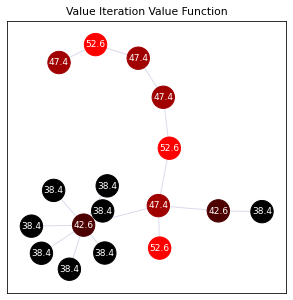

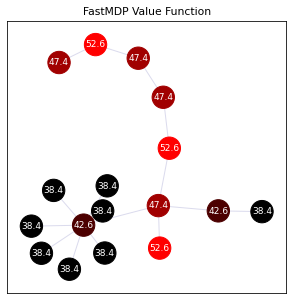

In [670]:
plot_compare( G, N, V_det, V_pred, file1='graph_mdp_multipos_valiter.eps', file2='graph_mdp_multipos_fastmpd.eps' )



## FastMDP-over-graph Function

Summarized into a convenient function

In [611]:

# for positive rewards
def fast_mdp_graph( N, rewards ):

  M = len(rewards) # number of peaks
  d = np.zeros( (N, M) )

  for m, (s_r, r_val) in enumerate(rewards):  # s_r is state where reward is located
    for s_i in range(N):
      # Distance from each state (s_i) to each positive reward (s_r) 
  
      # extract the distance from the dict into our more convenient 2D
      # numpy array.  when we index this, we are saying distance from 
      # state s_i to the m'th peak.
      d[s_i,m] = dists[s_i][s_r]  

  # Compute the magnitude of the peak.
  peak_mags = np.zeros( (M) )

  for m, (s_r, r_val) in enumerate(rewards):  # s_r is state where reward is located
    peak_mags[m] = r_val / (1 - gamma**2)  # assuming each peak has pos reward of 10 right now

    #print( f'peak {m} magnitude {peak_mags[m]}  value function {V_det[s_r]}' )

  # Compute the value function using the FastMDP method

  # First, compute the value function that would result from each peak
  V_pred_each = np.zeros( (M, N) )  # num peaks X num states
  for m in range(len(rewards)):  # s_r is state where reward is located
    V_pred_each[m,:] = peak_mags[m] * gamma ** d[:,m]

  # Now determine the value function by performing the max over each peak
  V_pred = np.max( V_pred_each, axis=0 )

  return V_pred
  
V_pred_2 = fast_mdp_graph( N, [ [s_r, 10] for s_r in pos_rewards ] )

In [612]:
V_pred_2 - V_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Negative reward

Some experimentation with multiple negative rewards.  Like I've found with negative rewards in 2D grid worlds, we see propagation outward until the boundary of a block of negative reward.  Individual negative point rewards don't propagate.

The standard positive form approach doesn't hold and is broken for a true MDP.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4]}
max_out_degree:  2
Building transition function


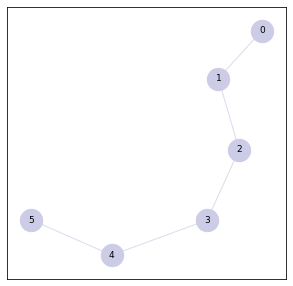

In [613]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = super_simple_debug_graph()

In [614]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ 
  ( int(N/2), 10 ),
  ]
neg_rewards = [ 
  (0, -50),
  (1, -50),
  #(2, -50),
  #(3, -50),
]

for (s_r, r_val) in pos_rewards:
  R[s_r] = r_val

for (s_r, r_val) in neg_rewards:
  R[s_r] = r_val


In [615]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = 0 * np.ones( (N) )  # a large negative but finite value
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
V_det

Solving MDP


array([-56.63162215,  -7.36845993,  47.36837785,  52.63154007,
        47.36837785,  42.63154007])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


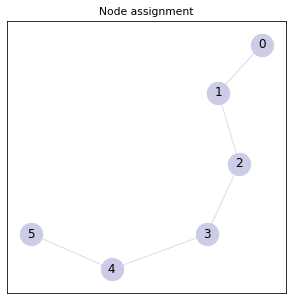

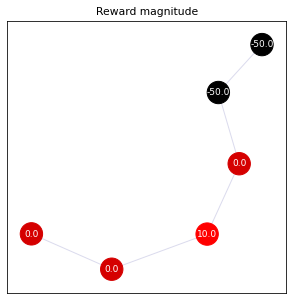

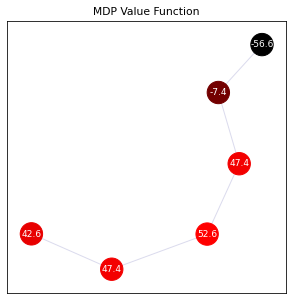

In [616]:

plot_mdp_result( G, pos, N, R, V_det )



In [617]:
# Solve positive rewards as a subproblem
V_pos = fast_mdp_graph( N, pos_rewards )

# Solve negative rewards as a subproblem in Standard Positive Form. 
# Update: this approach is broken, won't apply to graph MDPs.
#V_neg = fast_mdp_graph( N, [ [ s_r, abs(r_val) ] for (s_r, r_val) in neg_rewards ] )

R_neg = np.zeros( (N) )
for s_r, r_val in neg_rewards:
  R_neg[ s_r ] = r_val


In [618]:
V_pos - V_det

array([9.50000432e+01, 5.00000389e+01, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05])

In [619]:
R_neg[ 0 ] = -50 + gamma * -50
R_neg[ 1 ] = -50
R_neg

array([-95., -50.,   0.,   0.,   0.,   0.])

In [620]:
(V_pos + R_neg) - V_det

array([4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05])

In [621]:
V_pred = V_pos + R_neg

In [622]:
V_pred - V_det

array([4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05])

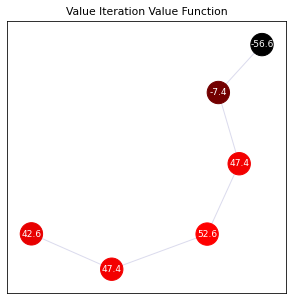

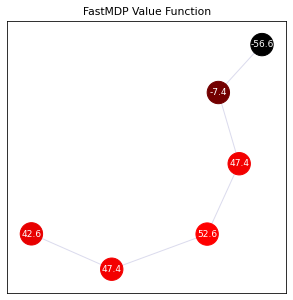

In [623]:
plot_compare( G, N, V_det, V_pred )

## Initial summary

So a general approach would be someting like identifying (or using primitives that tell you) where adjacent / blocks of reward are, identify the center, propagate outward from the center, then add this to the normal value function.

Another trick here is going to be downhill.  If the graph is acyclic this should be pretty easily done by applying the negative penalty, and then moving downward in the distance from each graph.  So another way of thinking about it is the distances from each peak form a gradient that this penalty follows.

# Negative reward with chasm

Noticed a special interesting case.  If the rewards are such that they go negative in the value function, then it cuts the graph into two disconnected pieces.  


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6, 8, 9], 6: [5, 7], 8: [5], 9: [5, 10, 11, 12, 13, 14, 15, 16], 7: [6], 10: [9], 11: [9], 12: [9], 13: [9], 14: [9], 15: [9], 16: [9]}
max_out_degree:  8
Building transition function


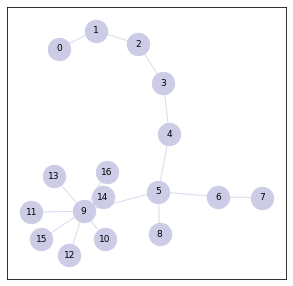

In [624]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = representative_graph()

In [625]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ 
  ( 5, 10 ),
  ]
neg_rewards = [ 
  (2, -50),
]

for (s_r, r_val) in pos_rewards:
  R[s_r] = r_val

for (s_r, r_val) in neg_rewards:
  R[s_r] = r_val


In [626]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = 0 * np.ones( (N) )  # a large negative but finite value
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
V_det

Solving MDP


array([  0.        ,   0.        , -11.63162215,  42.63154007,
        47.36837785,  52.63154007,  47.36837785,  42.63154007,
        47.36837785,  47.36837785,  42.63154007,  42.63154007,
        42.63154007,  42.63154007,  42.63154007,  42.63154007,
        42.63154007])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


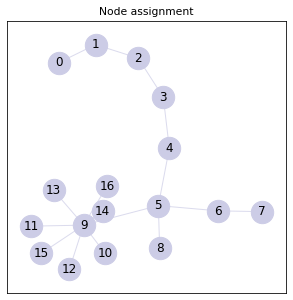

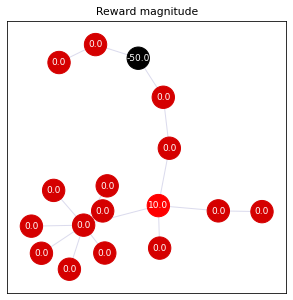

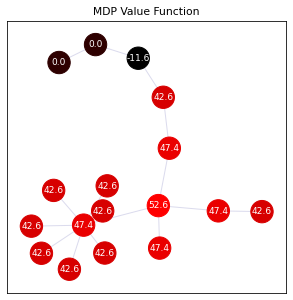

In [627]:
plot_mdp_result( G, pos, N, R, V_det, file_prefix='neg_chasm' )

What's interesting here is nodes 0 and 1 are on the other side of the -50 reward at 2.  The -50 reward at 2 results in a value of -11.6.  It is never advantageous to step from node 1 (value 0) to node 2 (value -11.6), so the only appropriate action is to step from node 1 to node 0.  From node 0, the only action is to step to node 1.  This sets up an infinite cycle where it's better to take no reward forever than to take that -50 penalty, as it is never worth it.  This effectively "cuts" the graph in two, where nodes 0 and 1 are off on their own separated from the rest of the graph.  If the negative reward at 2 were a smaller value such that the value at 2 remained positive, then we wouldn't see this "cutting" behavior.

# Negative reward without chasm



Now let's demonstrate the above by making that reward smaller so that node 2 doesn't go negative.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6, 8, 9], 6: [5, 7], 8: [5], 9: [5, 10, 11, 12, 13, 14, 15, 16], 7: [6], 10: [9], 11: [9], 12: [9], 13: [9], 14: [9], 15: [9], 16: [9]}
max_out_degree:  8
Building transition function


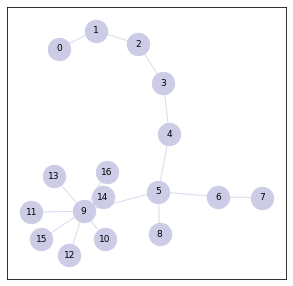

In [691]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = representative_graph()

In [692]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ 
  ( 5, 10 ),
  ]
neg_rewards = [ 
  (2, -10),
]

for (s_r, r_val) in pos_rewards:
  R[s_r] = r_val

for (s_r, r_val) in neg_rewards:
  R[s_r] = r_val


In [693]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = 0 * np.ones( (N) )  # a large negative but finite value
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
V_det

Solving MDP


array([22.97837785, 25.53154007, 28.36837785, 42.63154007, 47.36837785,
       52.63154007, 47.36837785, 42.63154007, 47.36837785, 47.36837785,
       42.63154007, 42.63154007, 42.63154007, 42.63154007, 42.63154007,
       42.63154007, 42.63154007])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


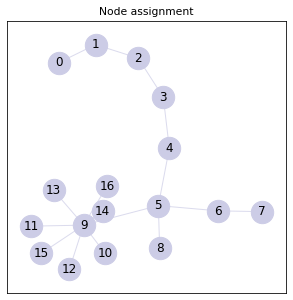

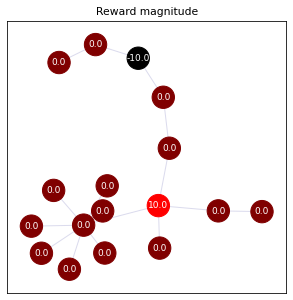

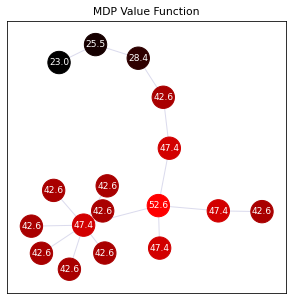

In [694]:
plot_mdp_result( G, pos, N, R, V_det, file_prefix='neg_no_chasm' )

Let's compute the solution we'd get with just the positive rewards

In [707]:
V_pred = fast_mdp_graph( N, pos_rewards )
print( V_pred )
print( V_det )

[31.07842105 34.53157895 38.36842105 42.63157895 47.36842105 52.63157895
 47.36842105 42.63157895 47.36842105 47.36842105 42.63157895 42.63157895
 42.63157895 42.63157895 42.63157895 42.63157895 42.63157895]
[22.97837785 25.53154007 28.36837785 42.63154007 47.36837785 52.63154007
 47.36837785 42.63154007 47.36837785 47.36837785 42.63154007 42.63154007
 42.63154007 42.63154007 42.63154007 42.63154007 42.63154007]


We can see that it is off:

In [696]:
V_pred - V_det

array([8.10004320e+00, 9.00003888e+00, 1.00000432e+01, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 4.32016321e-05, 3.88814689e-05, 3.88814689e-05,
       3.88814689e-05, 3.88814689e-05, 3.88814689e-05, 3.88814689e-05,
       3.88814689e-05])

We need to account for the -10 penalty at node 2.  The penalty then flows "downhill" away from the positive reward, being discounted by gamma at each step.

In [697]:
R_neg = np.zeros_like( V_pred )

R_neg[2] = -10
R_neg[1] = gamma * -10
R_neg[0] = gamma**2 * -10

We can see that when we add this to the positive value function, we arrive at the value iteration answer (to within the bellman residual.)

In [698]:
(V_pred + R_neg) - V_det

array([4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 3.88814689e-05, 4.32016321e-05, 3.88814689e-05,
       4.32016321e-05, 4.32016321e-05, 3.88814689e-05, 3.88814689e-05,
       3.88814689e-05, 3.88814689e-05, 3.88814689e-05, 3.88814689e-05,
       3.88814689e-05])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


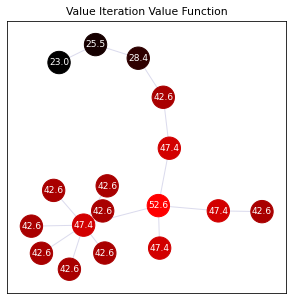

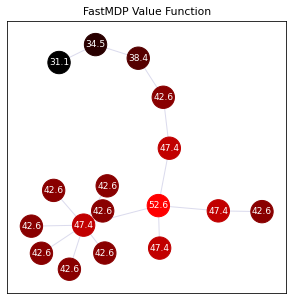

In [699]:
plot_compare( G, N, V_det, V_pred, file1='neg_no_chasm_valiter.eps', file2='neg_no_chasm_fastmdp.eps' )

This suggests that in order to solve a problem with negative reward, the algorithm will need to account for negative rewards along the path to positive rewards.  If the algorithm can consider the effect of negative rewards of this nature, then it can conceivably compute the value function.  However, it also means that every possible path to each reward would need to be considered, which feels like combinatorial explosion.

# Negative reward with multiple positive rewards



Here we want to demonstrate how to handle the value function when there are multiple positive rewards.  This boils down to determining the value function that would result from each positive reward, building the "downhill" gradient with respect to each positive reward, and applying the penalty to each positive rewards value function accordingly.  Once those value functions with negative reward are computed, we take the max over each state (node in the graph) to arrive at the value function.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


edges:  {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4, 6, 8, 9], 6: [5, 7], 8: [5], 9: [5, 10, 11, 12, 13, 14, 15, 16], 7: [6], 10: [9], 11: [9], 12: [9], 13: [9], 14: [9], 15: [9], 16: [9]}
max_out_degree:  8
Building transition function


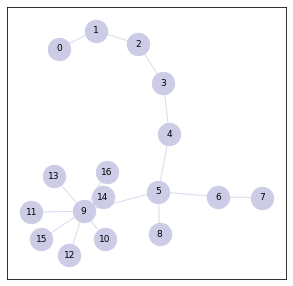

In [708]:
(G, nodes, N, pos, edges, max_out_degree, T, dists ) = representative_graph()

Now we will define some hand-picked rewards that will help us illustrate how this works.

In [709]:
# Let's create a reward function defined over the graph

R = np.zeros( (N) )

# Define the location of a couple of positive rewards
pos_rewards = [ 
  ( 9, 10 ),
  ( 2, 10 ),
  ]
neg_rewards = [ 
  (5, -10),
]

for (s_r, r_val) in pos_rewards:
  R[s_r] = r_val

for (s_r, r_val) in neg_rewards:
  R[s_r] = r_val


In [710]:
# use same epsilon and gamma as earlier

print( "Solving MDP" )
V = 0 * np.ones( (N) )  # a large negative but finite value
V_det = numba_value_iteration_st( N, V, T, R, epsilon, gamma )
V_det

Solving MDP


array([42.63154007, 47.36837785, 52.63154007, 47.36837785, 42.63154007,
       37.36837785, 33.63154007, 30.26837785, 33.63154007, 52.63154007,
       47.36837785, 47.36837785, 47.36837785, 47.36837785, 47.36837785,
       47.36837785, 47.36837785])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


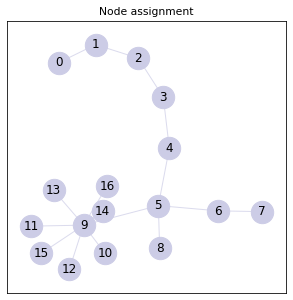

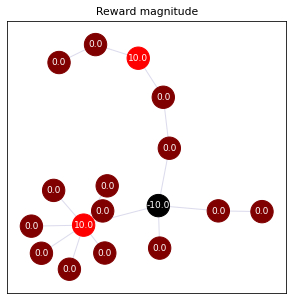

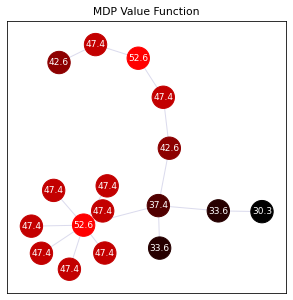

In [711]:
plot_mdp_result( G, pos, N, R, V_det, file_prefix='correct_multipos_neg' )

Let's compute the solution we'd get with just the positive rewards

In [712]:
V_pred = fast_mdp_graph( N, pos_rewards )


Let's take a look at how this compares to the true value function.  We can see at node 5, that in the true value function the value is 37.4 while in the positive-only value function it is 47.4, so it's clear that the penalty is being taken and that the policy will be to go from node 5 to node 9.  Nodes 6, 7, and 8 are "downhill" from node 5, so the penatly of -10 is discounted down those paths.


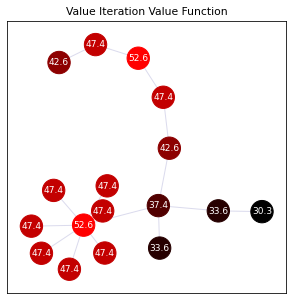

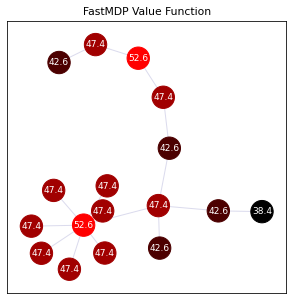

In [713]:
plot_compare( G, N, V_det, V_pred )


What isn't obvious is that the way to compute this resulting value function is to compute the value function with respect to each positive reward at nodes 9 and 2, applying the penalty at node 5 to each value function.

Let's compute the value function first for the reward at node 9, then the reward at node 2.


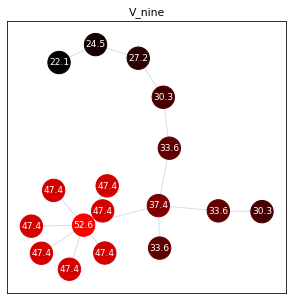

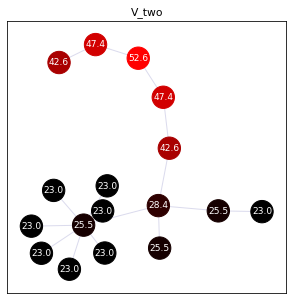

In [714]:
pos_rewards = [ 
  ( 9, 10 ),
  ( 2, 10 ),
  ]

V_nine = fast_mdp_graph( N, [ [ 9, 10 ] ] )
# Apply the penalty at node 5
V_nine[5] += -10
# Now the discounted penalties
# First the path down node 6 and 7
V_nine[6] += -10 * gamma
V_nine[7] += -10 * gamma**2
# The path that goes to node 8
V_nine[8] += -10 * gamma
# Then the path that goes down node 4 to 0.
V_nine[4] += -10 * gamma
V_nine[3] += -10 * gamma**2
V_nine[2] += -10 * gamma**3
V_nine[1] += -10 * gamma**4
V_nine[0] += -10 * gamma**5

V_two  = fast_mdp_graph( N, [ [ 2, 10 ] ] )
# Apply the penalty at node 5
V_two[5] += -10
# Now the discounted penalties
# First the path down node 6 and 7
V_two[6] += -10 * gamma
V_two[7] += -10 * gamma**2
# The path that goes to node 8
V_two[8] += -10 * gamma
# Then the path that goes to node 9 
V_two[9] += -10 * gamma
# And then all the nodes hanging off of node 9
V_two[10] += -10 * gamma**2
V_two[11] += -10 * gamma**2
V_two[12] += -10 * gamma**2
V_two[13] += -10 * gamma**2
V_two[14] += -10 * gamma**2
V_two[15] += -10 * gamma**2
V_two[16] += -10 * gamma**2


plot_compare( G, N, V_nine, V_two, title1="V_nine", title2="V_two" )

If we take the max over these two value functions, we will arrive at the value iteration solution.



In [715]:
V_pred = np.maximum( V_nine, V_two )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


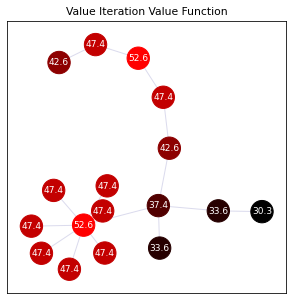

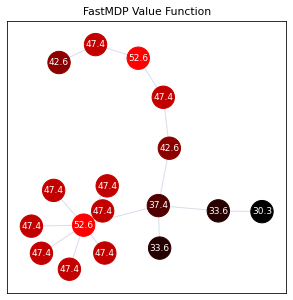

In [717]:
plot_compare( G, N, V_det, V_pred, file1='correct_multipos_neg_valiter.eps', file2='correct_multipos_neg_fastmpd.eps' )

# Conclusions

So we are starting to see a general solution.  We need to know where all the positive rewards are and compute distance from these positive rewards through the graph.  We need to know where the negative rewards are so that we can apply the penalties to the reward function and so that they can flow "downhill" away from the positive rewards.  We can then compute the value function that results from any single positive reward and all of the negative rewards, which we can term the *augmented value function* for each positive reward.  We then take the element-wise max over all of the augmented value functions to obtain the true value function.


TODO:  Implement this approach.  Need the distance functions from each positive reward so that we can apply the discounted reward penalties.

Will also need to account for minimum cycle, uncrossable chasm cases?